# Inception Neural Network

Welcome to the fourth HDA laboratory! In this notebook, you will implement an advanced architecture: the **Inception-v4 network.** The architecture was proposed by [Google developers](https://arxiv.org/pdf/1602.07261.pdf) for image classification.

**In this assignment, you will:**
- Implement the basic building blocks of Inception-v4. 
- Put together these building blocks to implement and train a state-of-the-art neural network for image classification. 

In [159]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Input
from tensorflow.keras.layers import Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pydot
from PIL import Image
from IPython.display import SVG
from load_utils import *
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
import scipy.misc
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import precision_recall_fscore_support, roc_curve, auc, accuracy_score, precision_recall_curve

# Dataset
For this lab, you will use the [**PatchCamelyon** dataset](https://github.com/basveeling/pcam). It consists of 327.680 color images (96 x 96px) extracted from histopathologic scans of lymph node sections. Each image is annotated with a binary label indicating the presence of metastatic tissue.
If the label is `1` it means that the center 32x32px region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label. 

In this notebook, you will use a smaller version of the dataset that consists of 1.200 images. Feel free to download the entire dataset to experiment with it (e.g., if you train the network with more examples, the performance of the designed classifier should increase).

The function `load_data()` defined in `resnet_utils.py`, loads the smaller dataset.

In [160]:
(x_train, y_train, meta_train), (x_test, y_test, meta_test) = load_data()

OSError: Unable to open file (unable to open file: name = 'pcamv1/camelyonpatch_level_2_split_train_x_cut.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [161]:
print('TRAIN SET, images: {}'.format(x_train.shape))
print('TRAIN SET, labels: {}'.format(y_train.shape))
train_length = y_train.shape[0]

print('TEST SET, images: {}'.format(x_test.shape))
print('TEST SET, labels: {}'.format(y_test.shape))
test_length = y_test.shape[0]

TRAIN SET, images: (5000, 96, 96, 3)
TRAIN SET, labels: (5000, 1)
TEST SET, images: (1000, 96, 96, 3)
TEST SET, labels: (1000, 1)


<ipython-input-162-28075f696925>:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1, 10, i+1)


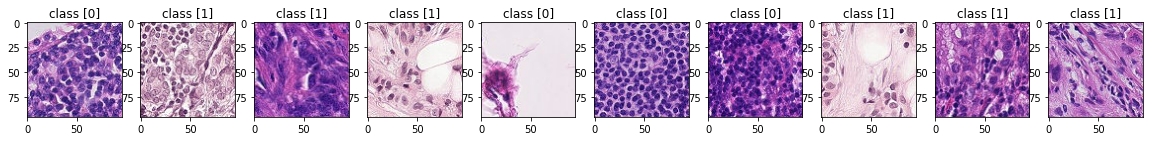

In [162]:
plt.figure(figsize=[20,10])
plt.subplot(1, 10, 1)
    
for i in range(10):
    plt.subplot(1, 10, i+1)
    image = x_train[i, :, :, :]
    plt.imshow(image)
    label = y_train[i]
    plt.title('class '+ str(label))
plt.show()

To train the models we will implement below on the image dataset, we use [ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) that generates batches of tensor image data. This class is useful when using image datasets as it allows applying real-time data augmentation. For the test generator we only apply normalization without data augmentation.

In [163]:
datagen_train = ImageDataGenerator(preprocessing_function=lambda x: x/255.,
                             width_shift_range=4,  # randomly shift images horizontally
                             height_shift_range=4,  # randomly shift images vertically 
                             horizontal_flip=True,  # randomly flip images
                             vertical_flip=True)  # randomly flip images

In [164]:
datagen_test = ImageDataGenerator(preprocessing_function=lambda x: x/255.)

In [165]:
batch_size = 32
train_steps = int(np.ceil(train_length/batch_size))
test_steps = int(np.ceil(test_length/batch_size))

# Inception network

In a pure Inception network, there are two different block types: the *Inception blocks* and the *Reduction blocks*.

Inception-v4 is composed of three Inception blocks, two Reduction ones and an initial stem block. 

<img src="images/inceptionv4.png" style="width:80%">
<caption><center>  <br> </center></caption>

**Note**: for the last activation we will use ``sigmoid`` with one output neuron (binary classification task).

## 1 - Inception-v4 blocks 
### 1.1 - Convolutional and batch normalization helper function
First of all, here below is implemented the ``conv2d_bn`` helper function that you will use in all the blocks of the Inception v4 network.

Use the following structure:
- CONV2D with $F$ filters of shape ($h$, $w$), stride of ($s_1$, $s_2$). 
- BatchNorm, normalizing the 'channels' axis.  
- ReLU activation function. 

In [25]:
# FUNCTION: conv2d_bn block

def conv2d_bn(X_input, filters, kernel_size, strides, padding='same', activation=None,
              name=None):
    """
    Implementation of a conv block as defined above
    
    Arguments:
    X_input -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    filters -- integer, defining the number of filters in the CONV layer
    kernel_size -- (f1, f2) tuple of integers, specifying the shape of the CONV kernel
    s -- integer, specifying the stride to be used
    padding -- padding approach to be used
    name -- name for the layers
    
    Returns:
    X -- output of the conv2d_bn block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'conv_'
    bn_name_base = 'bn_'

    X = Conv2D(filters = filters, kernel_size = kernel_size, strides = strides, 
               padding = padding, name = conv_name_base + name, 
               kernel_initializer = glorot_uniform(seed=0))(X_input)
    X = BatchNormalization(axis = 3, name = bn_name_base + name)(X)
    if activation is not None:
        X = Activation(activation)(X)
    return X

### 1.2 - The stem block

The stem block is designed as follows:

<img src="images/stem.png" style="width:70%">
<caption><center> Stem block. </center></caption>

Implement below all the steps by taking advantage of the above implemented ``conv2d_bn`` function for the blue rectangles. The values for the kernel sizes and the strides are specified in each block, use stride 1x1 when it is not specified. Use padding "valid" when the letter *V* appears otherwise use padding "same". E.g., the first layer has the following parameters: 32 filters of shape (3, 3), stride of (2, 2), padding "valid" while the third one is composed of 64 filters of shape (3, 3), stride of (1, 1), padding "same".

For the **Filter concat** layers (orange rectangles), use [tf.concat](https://www.tensorflow.org/api_docs/python/tf/concat) and concatenate along the 'channel' axis (axis=3).

As in laboratory 6, you can add a name for each of the layers. Use 0 as the seed for the random initialization to reproduce the expected output.

**Note** that the last conv block has ``stride = 2`` and the max pooling layer has ``kernel = (3, 3)``


In [142]:
# FUNCTION: stem_block

def stem_block(X_input):
    """
    Implementation of the stem block as defined above
    
    Arguments:
    X_input -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    
    Returns:
    X -- output of the stem block, tensor of shape (n_H, n_W, n_C)
    """
    
    # First conv 
    X = conv2d_bn(X_input, filters=32, kernel_size=(3,3), strides=(2,2), padding='valid',
                activation='relu', name='stage_1_a') 
    
    # Second conv
    X = conv2d_bn(X, filters=32, kernel_size=(3,3), strides=(1,1), padding='valid', 
                activation='relu', name='stage_1_b') 
    # Third conv
    X = conv2d_bn(X, filters=64, kernel_size=(3,3), strides=(1,1), padding='same',
                activation='relu', name='stage_1_c') 

    # First branch: max pooling
    branch1 = MaxPooling2D(pool_size=(3,3), strides=2, padding='valid')(X)

    # Second branch: conv
    branch2 = conv2d_bn(X, filters=96, kernel_size=(3,3), strides=(2,2), padding='valid',
                          activation='relu', name='stage_1_d') 

    # print ('stage 1: ')
    # print ('branch1 shape: ', branch1.shape)
    # print ('branch2 shape: ', branch2.shape)

    # Concatenate (1) branch1 and branch2 along the channel axis
    X = tf.concat([branch1, branch2], axis=3)
    # print ('concat shape: ', X.shape)

    # First branch: 2 convs
    branch1 = conv2d_bn(X, filters=64, kernel_size=(1,1), strides=(1,1), padding='same',
                            activation='relu', name='stage_2_a') 
    branch1 = conv2d_bn(branch1, filters=96, kernel_size=(3,3), strides=(1,1), padding='valid',
                            activation='relu', name='stage_2_b') 
    
    # print ('stage 2: ')
    # print ('branch1 shape: ', branch1.shape)

    # Second branch: 4 convs
    branch2 = conv2d_bn(X, filters=64, kernel_size=(1,1), strides=(1,1), padding='same',
                            activation='relu', name='stage_2_c') 
    branch2 = conv2d_bn(branch2, filters=64, kernel_size=(7,1), strides=(1,1), padding='same',
                            activation='relu', name='stage_2_d')  
    branch2 = conv2d_bn(branch2, filters=64, kernel_size=(1,7), strides=(1,1), padding='same',
                            activation='relu', name='stage_2_e') 
    branch2 = conv2d_bn(branch2, filters=96, kernel_size=(3,3), strides=(1,1), padding='valid',
                            activation='relu', name='stage_2_f') 

    # print ('branch2 shape: ', branch2.shape)
        
    # Concatenate (2) branch1 and branch2 along the channel axis
    X = tf.concat([branch1, branch2], axis=3)
    # print ('concat shape: ', X.shape)

    # First branch: conv
    branch1 = conv2d_bn(X, filters=192, kernel_size=(3,3), strides=(2,2), padding='valid',
                            activation='relu', name='stage_3_a')
                    
    # Second branch: max pooling
    branch2 = MaxPooling2D( pool_size=(3,3), strides=2, padding='valid')(X)

    # print ('stage 3: ')
    # print ('branch1 shape: ', branch1.shape)
    # print ('branch2 shape: ', branch2.shape)

    # Concatenate (3) branch1 and branch2 along the channel axis
    X = tf.concat([branch1, branch2], axis=3)

    # print ('concat shape: ', X.shape)
    
    return X

In [143]:
tf.random.set_seed(1)
X_inp = tf.random.normal((4, 100, 100, 3), dtype=tf.dtypes.float32)

X_out = stem_block(X_inp)
print("shape output" + str(X_out.shape))
print("out = " + str(X_out[:, 0, 0, 0]))

shape output(4, 10, 10, 384)
out = tf.Tensor([-0.25641742 -0.01279086 -0.28457257 -0.10633448], shape=(4,), dtype=float32)


**Expected Output**:

<table>
    <tr>
        <td>
            out
        </td>
        <td>
           [ 0.01137414   0.         0.01842478   0.         ]
        </td>
    </tr>

</table>

### 1.3 - The Inception-A block

Implement below the Inception-A block as detailed in the figure:

<img src="images/inception_A.png" style="width:50%">
<caption><center> Inception-A block. </center></caption>

**Note** The average pooling has ``pool_size = (3, 3)`` and ``strides = (1, 1)``

In [144]:
# FUNCTION: Inception-A block

def inception_a_block(X_input, base_name):
    """
    Implementation of the Inception-A block
    
    Arguments:
    X_input -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    
    Returns:
    X -- output of the block, tensor of shape (n_H, n_W, n_C)
    """

    # Branch 1
    branch1 = AveragePooling2D(pool_size=(3,3), strides=(1,1),  padding='same',)(X_input)
    branch1 = conv2d_bn(branch1, filters=96, kernel_size=(1,1), strides=(1,1), padding='same',
                            activation='relu', name=base_name + '_branch1_a')
    
    # Branch 2
    branch2 = conv2d_bn(X_input, filters=96, kernel_size=(1,1), strides=(1,1), padding='same',
                            activation='relu', name=base_name + '_branch2_a')
    
    # Branch 3
    branch3 = conv2d_bn(X_input, filters=64, kernel_size=(1,1), strides=(1,1), padding='same',
                            activation='relu', name=base_name + '_branch3_a')
    branch3 = conv2d_bn(branch3, filters=96, kernel_size=(3,3), strides=(1,1), padding='same',
                            activation='relu', name=base_name + '_branch3_b')

    # Branch 4
    branch4 =  conv2d_bn(X_input, filters=64, kernel_size=(1,1), strides=(1,1), padding='same',
                            activation='relu', name=base_name + '_branch4_a')
    branch4 = conv2d_bn(branch4, filters=96, kernel_size=(3,3), strides=(1,1), padding='same',
                            activation='relu', name=base_name + '_branch4_b')
    branch4 = conv2d_bn(branch4, filters=96, kernel_size=(3,3), strides=(1,1), padding='same',
                            activation='relu', name=base_name + '_branch4_c')

    # Concatenate branch1, branch2, branch3 and branch4 along the channel axis
    # print ('branch1 shape: ', branch1.shape)
    # print ('branch2 shape: ', branch2.shape)
    # print ('branch3 shape: ', branch3.shape)
    # print ('branch4 shape: ', branch4.shape)
    X = tf.concat([branch1, branch2, branch3, branch4], axis=3)
        
    return X

In [145]:
tf.random.set_seed(1)
X_inp = tf.random.normal((4, 100, 100, 3), dtype=tf.dtypes.float32)

X_out = inception_a_block(X_inp, 'a')
print("shape output" + str(X_out.shape))
print("out = " + str(X_out[:, 0, 0, 0]))

shape output(4, 100, 100, 384)
out = tf.Tensor([-0.1029806  -0.20333546 -0.0289089   0.08010338], shape=(4,), dtype=float32)


**Expected Output**:

<table>
    <tr>
        <td>
            out
        </td>
        <td>
           [ 0.09909103 0.18648545 0.01800423 0.        ]
        </td>
    </tr>

</table>

### 1.4 - The Inception-B block

Implement below the Inception-B block as detailed in the figure:

<img src="images/inception_B.png" style="width:50%">
<caption><center> Inception-B block. </center></caption>

**Note** The average pooling has ``pool_size = (3, 3)`` and ``strides = (1, 1)``. In the third branch, the last convolutional layer has kernel of size (7, 1).

In [146]:
# FUNCTION: Inception-B block

def inception_b_block(X_input, base_name):
    """
    Implementation of the Inception-B block
    
    Arguments:
    X_input -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    
    Returns:
    X -- output of the block, tensor of shape (n_H, n_W, n_C)
    """
    # Branch 1
    branch1 = AveragePooling2D(pool_size=(3,3), strides=(1,1),  padding='same',)(X_input)
    branch1 = conv2d_bn(branch1, filters=128, kernel_size=(1,1), strides=(1,1), padding='same',
                            activation='relu', name=base_name + '_branch1_a')
    
    # Branch 2
    branch2 = conv2d_bn(X_input, filters=384, kernel_size=(1,1), strides=(1,1), padding='same',
                            activation='relu', name=base_name + '_branch2_a')   
    
    # Branch 3
    branch3 = conv2d_bn(X_input, filters=192, kernel_size=(1,1), strides=(1,1), padding='same',
                            activation='relu', name=base_name + '_branch3_a')
    branch3 = conv2d_bn(branch3, filters=224, kernel_size=(1,7), strides=(1,1), padding='same',
                            activation='relu', name=base_name + '_branch3_b')
    branch3 = conv2d_bn(branch3, filters=256, kernel_size=(7,1), strides=(1,1), padding='same',
                            activation='relu', name=base_name + '_branch3_c')


    # Branch 4
    branch4 = conv2d_bn(X_input, filters=192, kernel_size=(1,1), strides=(1,1), padding='same',
                            activation='relu', name=base_name + '_branch4_a')   
    branch4 = conv2d_bn(branch4, filters=192, kernel_size=(7,1), strides=(1,1), padding='same',
                            activation='relu', name=base_name + '_branch4_b')
    branch4 = conv2d_bn(branch4, filters=224, kernel_size=(1,7), strides=(1,1), padding='same',
                            activation='relu', name=base_name + '_branch4_c')
    branch4 = conv2d_bn(branch4, filters=224, kernel_size=(7,1), strides=(1,1), padding='same',
                            activation='relu', name=base_name + '_branch4_d')
    branch4 = conv2d_bn(branch4, filters=256, kernel_size=(1,7), strides=(1,1), padding='same',
                            activation='relu', name=base_name + '_branch4_e')

    # Concatenate branch1, branch2, branch3 and branch4 along the channel axis
    X = tf.concat([branch1, branch2, branch3, branch4], axis=3)
        
    return X

In [147]:
tf.random.set_seed(1)
X_inp = tf.random.normal((4, 100, 100, 3), dtype=tf.dtypes.float32)

X_out = inception_b_block(X_inp, 'b')
print("shape output" + str(X_out.shape))
print("out = " + str(X_out[:, 0, 0, 0]))

shape output(4, 100, 100, 1024)
out = tf.Tensor([-0.10972138 -0.11960661  0.02537902 -0.04360325], shape=(4,), dtype=float32)


**Expected Output**:

<table>
    <tr>
        <td>
            out
        </td>
        <td>
           [ 0.09139545 0.11461768 0.         0.03276341 ]
        </td>
    </tr>

</table>

### 1.5 - The Inception-C block

Implement below the Inception-C block as detailed in the figure:

<img src="images/inception_C.png" style="width:50%">
<caption><center> Inception-C block. </center></caption>

**Note** The average pooling has ``pool_size = (3, 3)`` and ``strides = (1, 1)``.

In [148]:
# FUNCTION: Inception-C block

def inception_c_block(X_input, base_name):
    """
    Implementation of the Inception-C block
    
    Arguments:
    X_input -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    
    Returns:
    X -- output of the block, tensor of shape (n_H, n_W, n_C)
    """

    ### START CODE HERE ###

    # Branch 1
    branch1 = AveragePooling2D(pool_size=(3,3), strides=(1,1),  padding='same',)(X_input)
    branch1 = conv2d_bn(branch1, filters=256, kernel_size=(1,1), strides=(1,1), padding='same',
                            activation='relu', name=base_name + '_branch1_a')
    
    # Branch 2
    branch2 = conv2d_bn(X_input, filters=256, kernel_size=(1,1), strides=(1,1), padding='same',
                            activation='relu', name=base_name + '_branch2_a')
    
    # Branch 3
    branch3 = conv2d_bn(X_input, filters=384, kernel_size=(1,1), strides=(1,1), padding='same',
                            activation='relu', name=base_name + '_branch3_a')
    branch3_1 = conv2d_bn(branch3, filters=256, kernel_size=(1,3), strides=(1,1), padding='same',
                            activation='relu', name=base_name + '_branch3_b')
    branch3_2 = conv2d_bn(branch3, filters=256, kernel_size=(3,1), strides=(1,1), padding='same',
                            activation='relu', name=base_name + '_branch3_c')
    branch3 = tf.concat([branch3_1, branch3_2], axis=3)

    # Branch 4
    branch4 = conv2d_bn(X_input, filters=384, kernel_size=(1,1), strides=(1,1), padding='same',
                            activation='relu', name=base_name + '_branch4_a')
    branch4 = conv2d_bn(branch4, filters=448, kernel_size=(3,1), strides=(1,1), padding='same',
                            activation='relu', name=base_name + '_branch4_b')

    branch4 = conv2d_bn(branch4, filters=512, kernel_size=(1,3), strides=(1,1), padding='same',
                            activation='relu', name=base_name + '_branch4_c')
    branch4_1 = conv2d_bn(branch4, filters=256, kernel_size=(1,3), strides=(1,1), padding='same',
                            activation='relu', name=base_name + '_branch4_d')
    branch4_2 = conv2d_bn(branch4, filters=256, kernel_size=(3,1), strides=(1,1), padding='same',
                            activation='relu', name=base_name + '_branch4_e')   

    branch4 = tf.concat([branch4_1, branch4_2], axis=3)

    # Concatenate branch1, branch2, branch3_1, branch3_2, branch4_1 and branch4_2 along the channel axis
    X = tf.concat([branch1, branch2, branch3, branch4], axis=3)
        
    return X

In [149]:
tf.random.set_seed(1)
X_inp = tf.random.normal((4, 100, 100, 3), dtype=tf.dtypes.float32)

X_out = inception_c_block(X_inp, 'c')
print("shape output" + str(X_out.shape))
print("out = " + str(X_out[:, 0, 0, 0]))

shape output(4, 100, 100, 1536)
out = tf.Tensor([-0.08682069 -0.07572836  0.03827442 -0.04915025], shape=(4,), dtype=float32)


**Expected Output**:

<table>
    <tr>
        <td>
            out
        </td>
        <td>
           [ 0.04224636 0.1296405  0.0542384  0.       ]
        </td>
    </tr>

</table>

### 1.6 - The Reduction-A block

Implement below the Reduction-A block as detailed in the figure:

<img src="images/reduction_A.png" style="width:40%">
<caption><center> Reduction-A block. </center></caption>

For the Inception-v4 the parameters are as follows:
- n = 384
- k = 192
- l = 224
- m = 256

In [150]:
# FUNCTION: Reduction-A block

def reduction_a_block(X_input):
    """
    Implementation of the Reduction-A block
    
    Arguments:
    X_input -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    
    Returns:
    X -- output of the block, tensor of shape (n_H, n_W, n_C)
    """
    n = 384
    k = 192
    l = 224
    m = 256

    # Branch 1
    branch1 = MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid')(X_input)
    
    # Branch 2
    branch2 = conv2d_bn(X_input, filters=n, kernel_size=(3,3), strides=(2,2), padding='valid',
                            activation='relu', name='reduction_a_branch2_a')
    
    # Branch 3
    branch3 = conv2d_bn(X_input, filters=k, kernel_size=(1,1), strides=(1,1), padding='same',
                            activation='relu', name='reduction_a_branch3_a')
    branch3 = conv2d_bn(branch3, filters=l, kernel_size=(3,3), strides=(1,1), padding='same',
                            activation='relu', name='reduction_a_branch3_b')
    branch3 = conv2d_bn(branch3, filters=m, kernel_size=(3,3), strides=(2,2), padding='valid',
                            activation='relu', name='reduction_a_branch3_c')        

    # Concatenate branch1, branch2 and branch3 along the channel axis
    X = tf.concat([branch1, branch2, branch3], axis=3)
        
    return X

In [151]:
tf.random.set_seed(1)
X_inp = tf.random.normal((4, 100, 100, 3), dtype=tf.dtypes.float32)

X_out = reduction_a_block(X_inp)
print("shape output" + str(X_out.shape))
print("out = " + str(X_out[:, 0, 0, 0]))

shape output(4, 49, 49, 643)
out = tf.Tensor([1.3573772  0.54856557 1.4745579  0.3727632 ], shape=(4,), dtype=float32)


**Expected Output**:

<table>
    <tr>
        <td>
            out
        </td>
        <td>
           [ 1.3573772  0.54856557 1.4745579  0.3727632 ]
        </td>
    </tr>

</table>

### 1.7 - The Reduction-B block

Implement below the Reduction-B block as detailed in the figure:

<img src="images/reduction_B.png" style="width:40%">
<caption><center> Reduction-B block. </center></caption>


In [152]:
# FUNCTION: Reduction-B block

def reduction_b_block(X_input, base_name=''):
    """
    Implementation of the Reduction-B block
    
    Arguments:
    X_input -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    
    Returns:
    X -- output of the block, tensor of shape (n_H, n_W, n_C)
    """


    # Branch 1
    branch1 = MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid')(X_input)
    
    # Branch 2
    branch2 = conv2d_bn(X_input, filters=192, kernel_size=(1,1), strides=(1,1), padding='same',
                            activation='relu', name=base_name+'reduction_b_branch2_a')
    branch2 = conv2d_bn(branch2, filters=192, kernel_size=(3,3), strides=(2,2), padding='valid',
                            activation='relu', name=base_name+'reduction_b_branch2_b')        
    
    # Branch 3
    branch3 = conv2d_bn(X_input, filters=256, kernel_size=(1,1), strides=(1,1), padding='same',
                            activation='relu', name=base_name+'reduction_b_branch3_a')        
    branch3 = conv2d_bn(branch3, filters=256, kernel_size=(1,7), strides=(1,1), padding='same',
                            activation='relu', name=base_name+'reduction_b_branch3_b')
    branch3 = conv2d_bn(branch3, filters=320, kernel_size=(7,1), strides=(1,1), padding='same',
                            activation='relu', name=base_name+'reduction_b_branch3_c')    
    branch3 = conv2d_bn(branch3, filters=320, kernel_size=(3,3), strides=(2,2), padding='valid',
                            activation='relu', name=base_name+'reduction_b_branch3_d')    
                        
    # Concatenate branch1, branch2 and branch3 along the channel axis
    X = tf.concat([branch1, branch2, branch3], axis=3)
    
    return X

In [153]:
tf.random.set_seed(1)
X_inp = tf.random.normal((4, 100, 100, 3), dtype=tf.dtypes.float32)

X_out = reduction_b_block(X_inp)
print("shape output" + str(X_out.shape))
print("out = " + str(X_out[:, 0, 0, 0]))

shape output(4, 49, 49, 515)
out = tf.Tensor([1.3573772  0.54856557 1.4745579  0.3727632 ], shape=(4,), dtype=float32)


**Expected Output**:

<table>
    <tr>
        <td>
            out
        </td>
        <td>
           [ 1.3573772  0.54856557 1.4745579  0.3727632 ]
        </td>
    </tr>

</table>

### 1.8 - Network construction

You have now implemented all the necessary blocks to build the Inception-v4 network. 

Refer to the above figure about the whole network and stack the blocks you implemented in the helper functions to build the Inception network.
Add a ``Flatten`` layer after the last ``AveragePooling2D`` layer. 

In [167]:
# FUNCTION: Inception-v4
from tensorflow.keras.activations import softmax

def Inceptionv4(input_shape):
    """
    Implementation of the Inception-v4 architecture

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """

    # Define the input as a tensor with shape input_shape (1 line)
    X_input = Input(input_shape)

    # Call the above functions for the stem, inception-a, reduction-a, inception-b, reduction-b and inception-c blocks
    X = stem_block(X_input)

    # Four Inception A blocks
    for i in range(4):  X = inception_a_block(X, 'A'+str(i+1))

    # Reduction A block
    X = reduction_a_block(X)

    # Seven Inception B blocks
    for i in range(7):  X = inception_b_block(X, 'B'+str(i+1))

    # Reduction B block
    X = reduction_b_block(X)

    # Three Inception C blocks
    for i in range(3):  X = inception_c_block(X, 'C'+str(i+1))

    # AVGPOOLUse "X = AveragePooling2D(...)(X)"
    kernel_pooling = X.get_shape()[1:3]
    X = AveragePooling2D(pool_size=kernel_pooling, strides=1, padding='same')(X)
    X = Flatten()(X)

    # Dropout
    X = Dropout(0.8)(X)
    X = softmax(X)

        
    # Create model
    model = Model(inputs = X_input, outputs = X, name='Inceptionv4')

    return model

## 2 - Network training
Create the model, using the correct input shape for the dataset, and compile it. Use `binary_crossentropy` for the loss as we need to solve a binary classification problem. As optimizer try this time `SGD` using ``optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)``.

In [180]:
model = Inceptionv4( (96, 96,3))
optimizer = tf.keras.optimizers.SGD(learning_rate=0.005) 

# Compile the model
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [181]:
model.summary()

Model: "Inceptionv4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 conv_stage_1_a (Conv2D)        (None, 47, 47, 32)   896         ['input_14[0][0]']               
                                                                                                  
 bn_stage_1_a (BatchNormalizati  (None, 47, 47, 32)  128         ['conv_stage_1_a[0][0]']         
 on)                                                                                              
                                                                                                  
 conv_stage_1_b (Conv2D)        (None, 45, 45, 32)   9248        ['bn_stage_1_a[0][0]'] 

Use the early stopping callback ([documentation here](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping)) to stop the training when the validation loss stops decreasing. 

In [182]:
# Create a callback for early stopping 
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6)

Fit the model on the data using real-time data augmentation. Use the method `flow` of `ImageDataGenerator` ([documentation here](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow)). In addition to the training data, specify `validation_data`, `steps_per_epoch`, `validation_steps` and `callbacks` (see [here](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit)). 

In [183]:
# Fit the model on batches with real-time data augmentation:
generator = ImageDataGenerator(validation_split=0.2)

train_generator = generator.flow(
    x_train, y_train, subset='training')

validation_generator = generator.flow(   
    x_train, y_train, subset='validation')

history = model.fit(train_generator, epochs=100, validation_data=validation_generator, 
                callbacks=[callback], steps_per_epoch=80, validation_steps=50)

Epoch 1/100
80/80 [==============================] - 149s 2s/step - loss: 6.1286 - accuracy: 3.9063e-04 - val_loss: 6.9615 - val_accuracy: 0.0000e+00
Epoch 2/100
80/80 [==============================] - 128s 2s/step - loss: 4.7730 - accuracy: 0.0000e+00
Epoch 3/100
80/80 [==============================] - 120s 1s/step - loss: 4.3542 - accuracy: 0.0016
Epoch 4/100
80/80 [==============================] - 120s 1s/step - loss: 4.2989 - accuracy: 0.0020
Epoch 5/100
80/80 [==============================] - 117s 1s/step - loss: 4.1400 - accuracy: 7.8125e-04
Epoch 6/100
80/80 [==============================] - 126s 2s/step - loss: 4.0464 - accuracy: 0.0000e+00
Epoch 7/100
80/80 [==============================] - 125s 2s/step - loss: 3.9889 - accuracy: 7.8125e-04
Epoch 8/100
80/80 [==============================] - 123s 2s/step - loss: 4.1144 - accuracy: 0.0012
Epoch 9/100
80/80 [==============================] - 120s 1s/step - loss: 3.8926 - accuracy: 0.0012
Epoch 10/100
80/80 [==============

KeyboardInterrupt: 

In [ ]:
model.save('my_inception_model.h5')

## 3 - Performance assessment

To load the pre-trained model and use it on the test set, uncomment the line in the cell below.

In [ ]:
# model = load_model('Inceptionv4.h5') 

### 3.1 - Model visualization
Run the code below to visualize your InceptionV4.

In [ ]:
! pip install pydot

In [ ]:
! brew install graphviz

graphviz 3.0.0 is already installed but outdated (so it will be upgraded).
==> Downloading https://ghcr.io/v2/homebrew/core/jasper/manifests/3.0.6_2
######################################################################## 100.0%
==> Downloading https://ghcr.io/v2/homebrew/core/jasper/blobs/sha256:8b646454b43
==> Downloading from https://pkg-containers.githubusercontent.com/ghcr1/blobs/sh
######################################################################## 100.0%
==> Downloading https://ghcr.io/v2/homebrew/core/netpbm/manifests/10.86.33
######################################################################## 100.0%
==> Downloading https://ghcr.io/v2/homebrew/core/netpbm/blobs/sha256:2aaa219cee1
==> Downloading from https://pkg-containers.githubusercontent.com/ghcr1/blobs/sh
######################################################################## 100.0%
==> Downloading https://ghcr.io/v2/homebrew/core/gdk-pixbuf/manifests/2.42.8_1
#####################################################

In [ ]:
plot_model(model, to_file='inception_model.png')

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


### 3.2 - Loss and accuracy
Compute the loss and accuracy on the test set.

In [ ]:
preds = model.evaluate(datagen_test.flow(x_test, y_test, batch_size=test_length, shuffle=False), steps=1)
print('Loss = {:.5f}'.format(preds[0]))
print('Test Accuracy = {:.2f}%'.format(preds[1]*100))

1/1 [==============================] - 7s 7s/step - loss: 3.9039 - accuracy: 0.0000e+00
Loss = 3.90393
Test Accuracy = 0.00%
